# Faster R-CNN in Pytorch with Example

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from skimage import io
from skimage.transform import resize
import matplotlib.pyplot as plt
import random
import matplotlib.patches as patches
from utils import *
import os

import torch
import torchvision
from torchvision import ops
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence

### Load Images

**Note:** The annotations should also contain the corresponding image path

In [3]:
class ObjectDetectionDataset(Dataset):
    def __init__(self, annotations_dir, img_size, name2idx):
        self.annotations_dir = annotations_dir
        self.img_size = img_size
        self.name2idx = name2idx
        
        self.img_data_all, self.gt_bboxes_all, self.gt_classes_all = self.get_data()
        
    def __len__(self):
        return self.img_data_all.size(dim=0)
    
    def __getitem__(self, idx):
        return self.img_data_all[idx], self.gt_bboxes_all[idx], self.gt_classes_all[idx]
        
    def get_data(self):
        gt_bboxes_all = []
        img_data_all = []
        gt_classes_all = []
        
        annotation_paths = [os.path.join(self.annotations_dir, ann_name) for ann_name in os.listdir(self.annotations_dir)]
        for ann_path in annotation_paths:
            # parse annotation
            gt_bboxes, img_path, gt_classes = parse_annotation(ann_path, self.img_size)
            
            # skip if the image path is not valid
            if (not img_path) or (not os.path.exists(img_path)):
                continue
            # read and resize image
            img = io.imread(img_path)
            img = resize(img, self.img_size)
            # convert image to torch tensor and reshape it so channels come first
            img_tensor = torch.from_numpy(img).permute(2, 0, 1)
            
            # encode class names as integers
            gt_classes_idx = torch.Tensor([self.name2idx[name] for name in gt_classes])
            
            gt_bboxes_all.append(gt_bboxes)
            img_data_all.append(img_tensor)
            gt_classes_all.append(gt_classes_idx)
        
        # pad bounding boxes and classes so they are of the same size
        gt_bboxes_pad = pad_sequence(gt_bboxes_all, batch_first=True, padding_value=-1)
        gt_classes_pad = pad_sequence(gt_classes_all, batch_first=True, padding_value=-1)
        # stack all images
        img_data_stacked = torch.stack(img_data_all, dim=0)
        
        return img_data_stacked.to(dtype=torch.float32), gt_bboxes_pad, gt_classes_pad

In [4]:
img_width = 640
img_height = 480
annotations_dir = "./data/annotations/"
name2idx = {'cat': 0, 'dog': 1}

#### Create Dataset and Dataloaders

In [5]:
od_dataset = ObjectDetectionDataset(annotations_dir, (img_height, img_width), name2idx)

In [6]:
od_dataloader = DataLoader(od_dataset, batch_size=2)

#### Grab a batch for demonstration

In [7]:
for img_batch, gt_bboxes_batch, gt_classes_batch in od_dataloader:
    img_data_all = img_batch
    gt_bboxes_all = gt_bboxes_batch
    gt_classes_all = gt_classes_batch
    break
    
img_data_all = img_data_all[:2]
gt_bboxes_all = gt_bboxes_all[:2]
gt_classes_all = gt_classes_all[:2]

### Display Images and Bounding Boxes

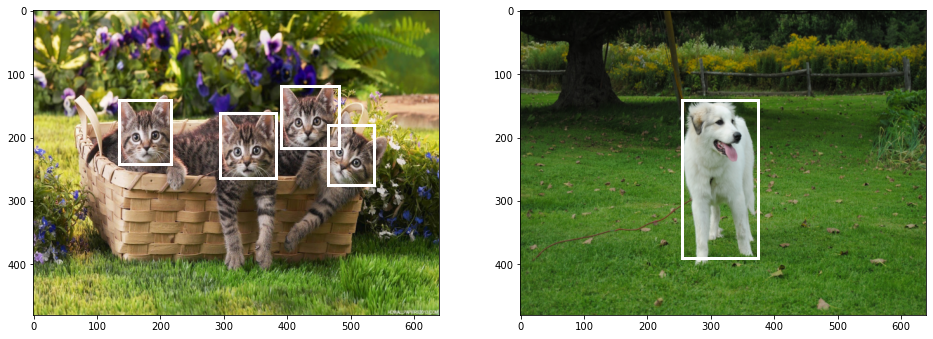

In [8]:
nrows, ncols = (1, 2)
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))

fig, axes = display_img(img_data_all, fig, axes)
fig, _ = display_bbox(gt_bboxes_all[0], fig, axes[0])
fig, _ = display_bbox(gt_bboxes_all[1], fig, axes[1])

## Convolutional Backbone Network

We will use the first 4 layers of resnet50 as our convolutional backbone

In [9]:
model = torchvision.models.resnet50(pretrained=True)

In [10]:
req_layers = list(model.children())[:8]
backbone = nn.Sequential(*req_layers)

In [11]:
# run the image through the backbone
out = backbone(img_data_all)

In [12]:
out_c, out_h, out_w = out.size(dim=1), out.size(dim=2), out.size(dim=3)

In [13]:
out_c, out_h, out_w

(2048, 15, 20)

#### Check how much the image has been down-scaled

In [14]:
width_scale_factor = img_width // out_w
height_scale_factor = img_height // out_h

### Visualize feature maps

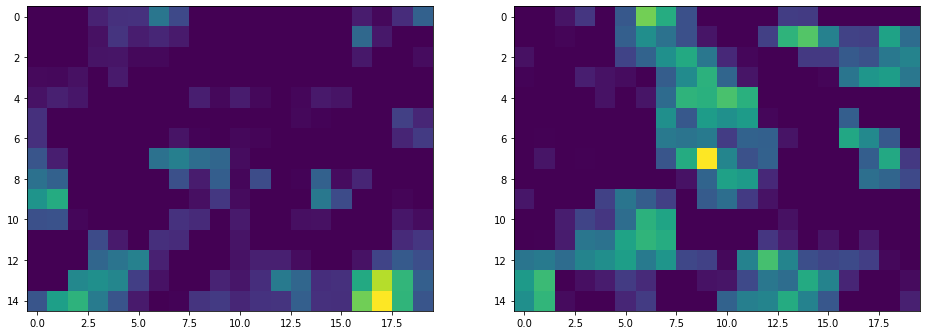

In [15]:
nrows, ncols = (1, 2)
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))

filters_data =[filters[0].detach().numpy() for filters in out[:2]]

fig, axes = display_img(filters_data, fig, axes)

### Generate and Plot Anchor Points

In [16]:
anc_pts_x, anc_pts_y = gen_anc_centers(out_size=(out_h, out_w))

### Display Grid Mapping

In [17]:
# project anchor centers onto the original image
anc_pts_x_proj = anc_pts_x.clone() * width_scale_factor 
anc_pts_y_proj = anc_pts_y.clone() * height_scale_factor

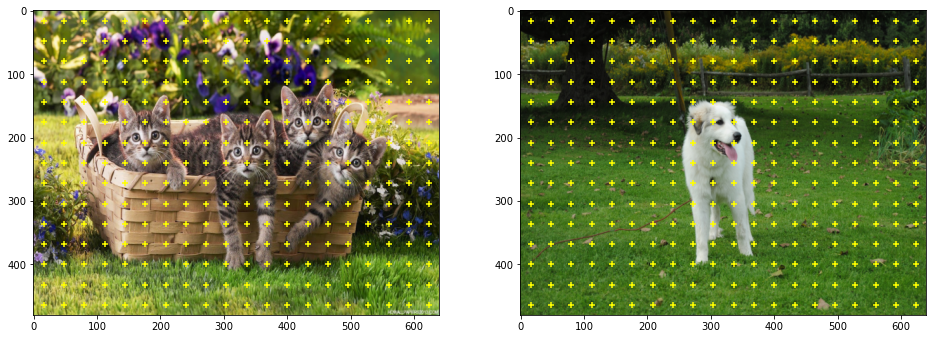

In [18]:
nrows, ncols = (1, 2)
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))
 
fig, axes = display_img(img_data_all, fig, axes)
fig, _ = display_grid(anc_pts_x_proj, anc_pts_y_proj, fig, axes[0])
fig, _ = display_grid(anc_pts_x_proj, anc_pts_y_proj, fig, axes[1])

### Create Anchor Boxes around Anchor points

In [19]:
anc_scales = [2, 4, 6]
anc_ratios = [0.5, 1, 1.5]
n_anc_boxes = len(anc_scales) * len(anc_ratios) # number of anchor boxes for each anchor point

anc_base = gen_anc_base(anc_pts_x, anc_pts_y, anc_scales, anc_ratios, (out_h, out_w))

In [20]:
# since all the images are scaled to the same size
# we can repeat the anchor base for all the images
anc_boxes_all = anc_base.repeat(img_data_all.size(dim=0), 1, 1, 1, 1)

### plot anchor boxes on a single anchor point

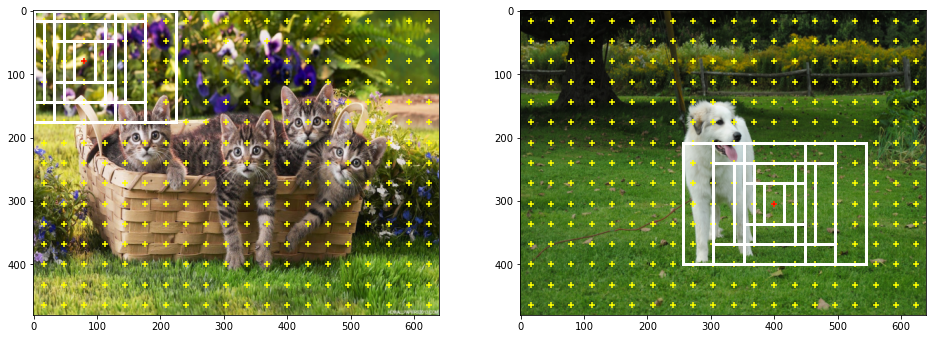

In [21]:
nrows, ncols = (1, 2)
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))

fig, axes = display_img(img_data_all, fig, axes)

# project anchor boxes to the image
anc_boxes_proj = project_bboxes(anc_boxes_all, width_scale_factor, height_scale_factor, mode='a2p')

# plot anchor boxes around selected anchor points
sp_1 = [2, 2]
sp_2 = [12, 9]
bboxes_1 = anc_boxes_proj[0][sp_1[0], sp_1[1]]
bboxes_2 = anc_boxes_proj[1][sp_2[0], sp_2[1]]

fig, _ = display_grid(anc_pts_x_proj, anc_pts_y_proj, fig, axes[0], (anc_pts_x_proj[sp_1[0]], anc_pts_y_proj[sp_1[1]]))
fig, _ = display_grid(anc_pts_x_proj, anc_pts_y_proj, fig, axes[1], (anc_pts_x_proj[sp_2[0]], anc_pts_y_proj[sp_2[1]]))
fig, _ = display_bbox(bboxes_1, fig, axes[0])
fig, _ = display_bbox(bboxes_2, fig, axes[1])

### plot all anchor boxes

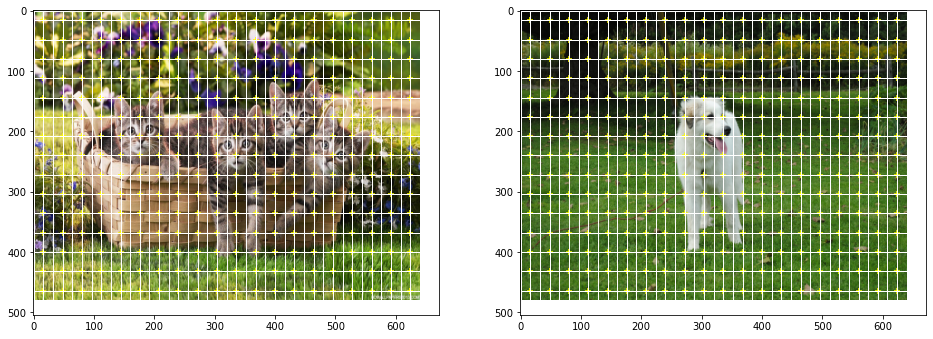

In [22]:
nrows, ncols = (1, 2)
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))

fig, axes = display_img(img_data_all, fig, axes)

# plot feature grid
fig, _ = display_grid(anc_pts_x_proj, anc_pts_y_proj, fig, axes[0])
fig, _ = display_grid(anc_pts_x_proj, anc_pts_y_proj, fig, axes[1])

# plot all anchor boxes
for x in range(anc_pts_x_proj.size(dim=0)):
    for y in range(anc_pts_y_proj.size(dim=0)):
        bboxes = anc_boxes_proj[0][x, y]
        fig, _ = display_bbox(bboxes, fig, axes[0], line_width=1)
        fig, _ = display_bbox(bboxes, fig, axes[1], line_width=1)

### Get Positive and Negative Anchors

In [23]:
pos_thresh = 0.7
neg_thresh = 0.3
batch_size = 2

# project gt bboxes onto the feature map
gt_bboxes_proj = project_bboxes(gt_bboxes_all, width_scale_factor, height_scale_factor, mode='p2a')

pos_anc_ind_all, neg_anc_ind_all, ious_all = get_req_anchors(batch_size, anc_boxes_all, gt_bboxes_proj, \
                                                            pos_thresh, neg_thresh)

#### Visualize positive anchor coordinates

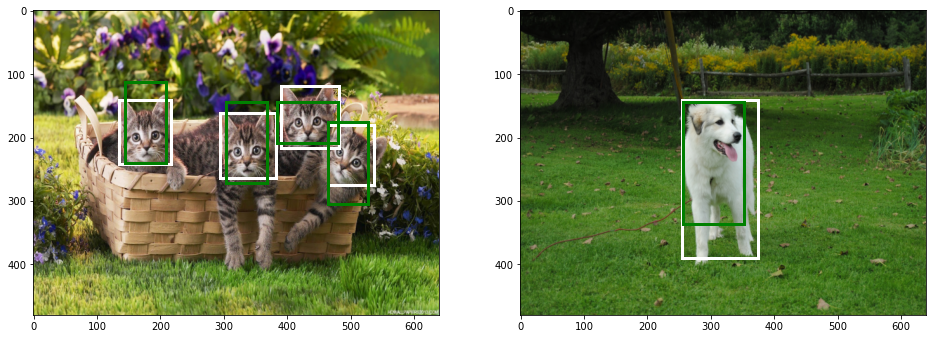

In [24]:
nrows, ncols = (1, 2)
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))

fig, axes = display_img(img_data_all, fig, axes)

# faltten anchor base
anc_boxes_proj = project_bboxes(anc_boxes_all, width_scale_factor, height_scale_factor, mode='a2p')
anc_boxes_flat = anc_boxes_proj.flatten(start_dim=1, end_dim=-2)

# plot groundtruth bboxes
fig, _ = display_bbox(gt_bboxes_all[0], fig, axes[0])
fig, _ = display_bbox(gt_bboxes_all[1], fig, axes[1])

# plot positive anchor boxes
fig, _ = display_bbox(anc_boxes_flat[0][pos_anc_ind_all[0]], fig, axes[0], color='g')
fig, _ = display_bbox(anc_boxes_flat[1][pos_anc_ind_all[1]], fig, axes[1], color='g')

#### Visualize negative anchor coordinates

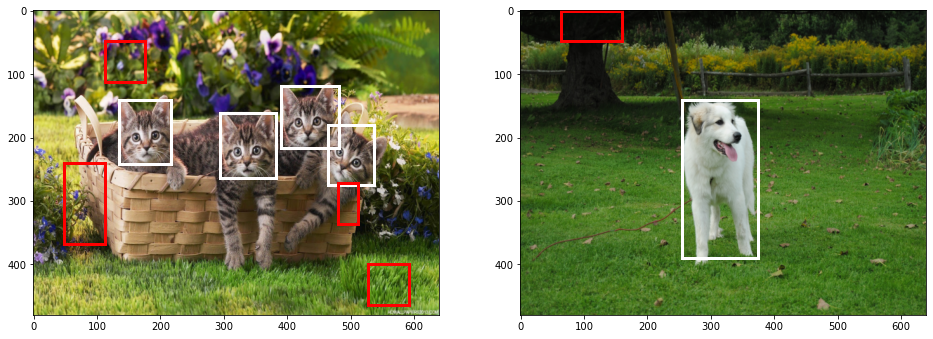

In [25]:
nrows, ncols = (1, 2)
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))

fig, axes = display_img(img_data_all, fig, axes)

# faltten anchor base
anc_boxes_proj = project_bboxes(anc_boxes_all, width_scale_factor, height_scale_factor, mode='a2p')
anc_boxes_flat = anc_boxes_proj.flatten(start_dim=1, end_dim=-2)

# plot groundtruth bboxes
fig, _ = display_bbox(gt_bboxes_all[0], fig, axes[0])
fig, _ = display_bbox(gt_bboxes_all[1], fig, axes[1])

# plot positive anchor boxes
fig, _ = display_bbox(anc_boxes_flat[0][neg_anc_ind_all[0]], fig, axes[0], color='r')
fig, _ = display_bbox(anc_boxes_flat[1][neg_anc_ind_all[1]], fig, axes[1], color='r')

### Map each positive anchor to its corresponding gt boox

In [26]:
gt_bboxes_map, gt_classes_map = map_gt(batch_size, pos_anc_ind_all, gt_bboxes_proj, gt_classes_all, ious_all)

### RPN Network

In [27]:
class FeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        model = torchvision.models.resnet50(pretrained=True)
        req_layers = list(model.children())[:8]
        self.backbone = nn.Sequential(*req_layers)
        
    def forward(self, img_data):
        return self.backbone(img_data)

In [28]:
class ProposalModule(nn.Module):
    def __init__(self, in_features, hidden_dim=512, n_anchors=9, p_dropout=0.3):
        super().__init__()
        self.n_anchors = n_anchors
        self.conv1 = nn.Conv2d(in_features, hidden_dim, kernel_size=3, padding=1)
        self.dropout = nn.Dropout(p_dropout)
        self.conf_head = nn.Conv2d(hidden_dim, n_anchors, kernel_size=1)
        self.reg_head = nn.Conv2d(hidden_dim, n_anchors * 4, kernel_size=1)
        
    def forward(self, feature_map, anc_boxes_all, pos_anc_ind_all=None, neg_anc_ind_all=None):
        
        # determine mode
        if pos_anc_ind_all is None or neg_anc_ind_all is None:
            mode = 'eval'
        else:
            mode = 'train'
            
        out = self.conv1(feature_map)
        out = F.relu(self.dropout(out))
        
        reg_offsets_pred = self.reg_head(out)
        conf_scores_pred = self.conf_head(out)
        
        # reshape offsets and generate proposals
        B, _, Hmap, Wmap = reg_offsets_pred.size()
        reg_offsets_resized = reg_offsets_pred.reshape(B, Hmap, Wmap, self.n_anchors, -1)
        proposals_all = generate_proposals(anc_boxes_all, reg_offsets_resized)
        
        if mode == 'train':
            # filter scores for +ve and -ve anchors
            # filter offsets for +ve anchors
            reg_offsets_pos_list, conf_scores_pos_list, conf_scores_neg_list = get_req_output(reg_offsets_pred, self.n_anchors, pos_anc_ind_all), \
                                                              get_req_output(conf_scores_pred, self.n_anchors, pos_anc_ind_all), \
                                                              get_req_output(conf_scores_pred, self.n_anchors, neg_anc_ind_all)

            # filter out positive proposals
            pos_proposals_list = [proposals_all[i][k] for i, k in enumerate(pos_anc_ind_all)]

            reg_offsets_pos = torch.cat(reg_offsets_pos_list)
            conf_scores_pos = torch.cat(conf_scores_pos_list)
            conf_scores_neg = torch.cat(conf_scores_neg_list)

            return reg_offsets_pos, conf_scores_pos, conf_scores_neg, pos_proposals_list
        
        elif mode == 'eval':
            conf_scores_pred = torch.sigmoid(conf_scores_pred)
            return conf_scores_pred, proposals_all

In [29]:
class RegionProposalNetwork(nn.Module):
    def __init__(self, img_size, out_size, out_channels):
        super().__init__()
        
        self.img_height, self.img_width = img_size
        self.out_h, self.out_w = out_size
        
        # downsampling scale factor 
        self.width_scale_factor = self.img_width // self.out_w
        self.height_scale_factor = self.img_height // self.out_h 
        
        # scales and ratios for anchor boxes
        self.anc_scales = [2, 4, 6]
        self.anc_ratios = [0.5, 1, 1.5]
        self.n_anc_boxes = len(anc_scales) * len(anc_ratios)
        
        # IoU thresholds for +ve and -ve anchors
        self.pos_thresh = 0.7
        self.neg_thresh = 0.3
        
        # weights for loss
        self.w_conf = 1
        self.w_reg = 5
        
        self.feature_extractor = FeatureExtractor()
        self.proposal_module = ProposalModule(out_channels, n_anchors=self.n_anc_boxes)
        
    def forward(self, images, gt_bboxes, gt_classes):
        batch_size = images.size(dim=0)
        feature_map = self.feature_extractor(images)
        
        # generate anchors
        anc_pts_x, anc_pts_y = gen_anc_centers(out_size=(self.out_h, self.out_w))
        anc_base = gen_anc_base(anc_pts_x, anc_pts_y, self.anc_scales, self.anc_ratios, (self.out_h, self.out_w))
        anc_boxes_all = anc_base.repeat(batch_size, 1, 1, 1, 1)
        
        # get positive and negative anchor indices
        gt_bboxes_proj = project_bboxes(gt_bboxes, self.width_scale_factor, self.height_scale_factor, mode='p2a')
        pos_anc_ind_all, neg_anc_ind_all, ious_all = get_req_anchors(batch_size, anc_boxes_all, gt_bboxes_proj, \
                                                                     self.pos_thresh, self.neg_thresh)
        
        # get offsets, conf scores, and proposals
        reg_offsets_pos, conf_scores_pos, conf_scores_neg, pos_proposals_list = self.proposal_module(feature_map, anc_boxes_all, \
                                                                                                     pos_anc_ind_all, neg_anc_ind_all)
        
        # compute loss
        gt_bboxes_map, gt_classes_map = map_gt(batch_size, pos_anc_ind_all, gt_bboxes_proj, \
                                                                gt_classes, ious_all)
        gt_classes_map = torch.cat(gt_classes_map) # stack all the classes
        
        gt_offsets = calc_gt_offsets_all(batch_size, pos_anc_ind_all, gt_bboxes_map, anc_boxes_all)
        conf_loss = calc_conf_loss(conf_scores_pos, conf_scores_neg)
        reg_loss = calc_bbox_reg_loss(gt_offsets, reg_offsets_pos)
        
        total_rpn_loss = self.w_conf * conf_loss + self.w_reg * reg_loss
        
        return total_rpn_loss, pos_proposals_list, feature_map, gt_classes_map
    
    def inference(self, images, conf_thresh, nms_thresh):
        batch_size = images.size(dim=0)
        feature_map = self.feature_extractor(images)
        
        # generate anchors
        anc_pts_x, anc_pts_y = gen_anc_centers(out_size=(self.out_h, self.out_w))
        anc_base = gen_anc_base(anc_pts_x, anc_pts_y, self.anc_scales, self.anc_ratios, (self.out_h, self.out_w))
        anc_boxes_all = anc_base.repeat(batch_size, 1, 1, 1, 1)
        
        # get proposals and conf scores
        conf_scores_pred, proposals_all = self.proposal_module(feature_map, anc_boxes_all)
        conf_scores_pred = conf_scores_pred.reshape(batch_size, -1)
        
        # filter out proposals based on conf threshold and nms threshold for each image
        proposals_final = []
        conf_scores_final = []
        for i in range(batch_size):
            conf_scores = conf_scores_pred[i]
            proposals = proposals_all[i]
            # filter based on confidence threshold
            conf_idx = torch.where(conf_scores >= conf_thresh)[0]
            conf_scores = conf_scores[conf_idx]
            proposals = proposals[conf_idx]
            # filter based on nms threshold
            nms_idx = ops.nms(proposals, conf_scores, nms_thresh)
            conf_scores = conf_scores[nms_idx]
            proposals = proposals[nms_idx]
            
            proposals_final.append(proposals)
            conf_scores_final.append(conf_scores)
            
        return proposals_final, conf_scores_final, feature_map

In [30]:
class ClassificationModule(nn.Module):
    def __init__(self, out_channels, n_classes, roi_size, hidden_dim=512, p_dropout=0.3):
        super().__init__()        
        self.roi_size = roi_size
        # hidden network
        self.avg_pool = nn.AvgPool2d(self.roi_size)
        self.fc = nn.Linear(out_channels, hidden_dim)
        self.dropout = nn.Dropout(p_dropout)
        
        # define classification head
        self.cls_head = nn.Linear(hidden_dim, n_classes)
        
    def forward(self, feature_map, proposals_list, gt_classes_map=None):
        
        if gt_classes_map is None:
            mode = 'eval'
        else:
            mode = 'train'
        
        # apply roi pooling on proposals followed by avg pooling
        roi_out = ops.roi_pool(feature_map, proposals_list, self.roi_size)
        roi_out = self.avg_pool(roi_out)
        
        # flatten the output
        roi_out = roi_out.squeeze(-1).squeeze(-1)
        
        # pass the output through the hidden network
        out = self.fc(roi_out)
        out = F.relu(self.dropout(out))
        
        # get the classification scores
        cls_scores = self.cls_head(out)
        
        if mode == 'eval':
            return cls_scores
        
        # compute cross entropy loss
        cls_loss = F.cross_entropy(cls_scores, gt_classes_map.long())
        
        return cls_loss

In [31]:
class TwoStageDetector(nn.Module):
    def __init__(self, img_size, out_size, out_channels, n_classes, roi_size):
        super().__init__() 
        self.rpn = RegionProposalNetwork(img_size, out_size, out_channels)
        self.classifier = ClassificationModule(out_channels, n_classes, roi_size)
        
    def forward(self, images, gt_bboxes, gt_classes):
        total_rpn_loss, pos_proposals_list, feature_map, gt_classes_map = self.rpn(images, gt_bboxes, gt_classes)
        cls_loss = self.classifier(feature_map, pos_proposals_list, gt_classes_map)
        total_loss = cls_loss + total_rpn_loss
        return total_loss
    
    def inference(self, images, conf_thresh=0.5, nms_thresh=0.7):
        batch_size = images.size(dim=0)
        proposals_final, conf_scores_final, feature_map = self.rpn.inference(images, conf_thresh, nms_thresh)
        cls_scores = self.classifier(feature_map, proposals_final)
        
        classes_final = []
        # slice cls_scores to map to corresponding image
        c = 0
        for i in range(batch_size):
            n_proposals = len(proposals_final[i]) # get the number of proposals for each image
            classes_final.append(cls_scores[c: c+n_proposals])
            c += n_proposals
            
        return proposals_final, conf_scores_final, classes_final

In [32]:
img_size = (img_height, img_width)
out_size = (out_h, out_w)
n_classes = len(name2idx)
roi_size = (2, 2)

detector = TwoStageDetector(img_size, out_size, out_c, n_classes, roi_size)

In [33]:
total_loss = detector(img_batch, gt_bboxes_batch, gt_classes_batch)
proposals_final, conf_scores_final, classes_final = detector.inference(img_batch)

### Training loop

In [34]:
learning_rate = 1e-3
n_epochs = 20

loss_list = training_loop(detector, learning_rate, od_dataloader, n_epochs)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [03:01<00:00,  9.05s/it]


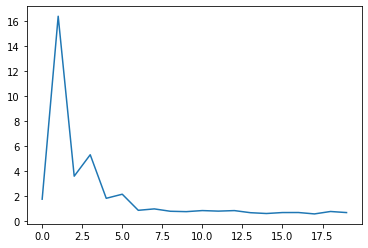

In [35]:
plt.plot(loss_list)